# Aggregating WRF-Hydro modeling application outputs to HUC12s: 2-Dimensional variables
**Author:** Kevin Sampson; NCAR

## Background
WRF-Hydro modeling application outputs should already have been processed from hourly to monthly summaries on the native WRF-Hydro/NWM grids. We will use these monthly datasets to process the zonal statistics at the HUC12 scale. This notebook aggregates the 1-Dimensional WRF-Hydro modeling application outputs. 

## Processing Environment
This workflow leverages dask and requires 150 GB of allocated memory. 
The python environment used is a conda environment 'wrfhydro_huc12_agg' here: 

/caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/niwaa_wrfhydro_monthly_huc12_agg/Training/02_Aggregation/wrfhydro_huc12_agg.yml


### Import Modules

In [1]:
# --- Import Modules --- #

# Import Python Core Modules
import sys
import os
import time
import datetime
from pathlib import Path

# Import Additional Modules
import numpy as np
import xarray as xr
import pandas as pd
import zarr
import flox.xarray

# Import functions from local repository
#sys.path.append(r'/glade/derecho/scratch/ksampson/Water_Budget/usgs_water/daily_retro')
sys.path.append(r'/caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/niwaa_wrfhydro_monthly_huc12_agg/Working')
from usgs_common import *

tic = time.time()
print('Process initiated at {0}'.format(time.ctime()))
# --- End Import Modules --- #

Process initiated at Tue Apr  1 12:16:20 2025


### Setup global variables, input and outputs and other options

In [3]:
# --- Globals --- #

# Choose a region subset
region = 'CONUS'

# Input directory containing model outputs
inDir = r'/caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/1D/'

# Input mapping file for model catchments to analysis catchments
Use_Mapping_File = True
Mapping_File = r'/caldera/hovenweep/projects/usgs/water/impd/hytest/niwaa_wrfhydro_monthly_huc12_aggregations_sample_data/HUC12_grids/Final_HUC12IDs.csv'

# Give a name to the zone dataset, which will be the name of the zone variable
zone_name = 'WBDHU12'

# Specify the field in the input file that contains local model catchment areas
area_field = 'NWM_Catchment_Area' 

# Specify the field in the input file that contains the mapping between model catchments and aggregation units
mapping_field = 'HUC12_FL' # Use this since it maps all flowlines to HUC12, an matches the catchment mapping

# Specify the field in the input file that contains the IDs of the model catchments
mapping_ID = 'ID'

# Peform spatial aggregation?
spatial_aggregation = True

# Resample the time variable?
resample_time = False
resample_time_period = "1D"

# Perform temporal subset on inputs?
temporal_subset = True
time_subset_bounds = slice('2011-10-01', '2012-09-30')     # Test Hytest batch (1 year)

# Fill NaN values in the Area_sqkm (used as weights on the variable) field with a particular value?
fill_na_value = 0     

# Specify units name - only used in output file names and netCDF variable attribute "units"
units = 'mm'

# Output directory
outDir = r'/caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/agg_out'

# Output filename pattern
output_pattern = 'CONUS_HUC12_1D_2011001_20120930'

# Select output formats
write_NC = True      # Output netCDF file
write_CSV = True     # Output CSV file

# 1D variables, input files, and other options
Variables = ['totOutflow', 'totInflow', 'deltaDepth', 'bucket_depth', 'totqBucket', 'totqSfcLatRunoff', 'totStreamflow'] # Manually specify variables
convert_to_mm = True                    # Output is in mm^3s^-1. Divide by m^2 and multiply by 1000 to get mm
convert_to_mm_list = ['totOutflow', 'totInflow', 'totqBucket', 'totqSfcLatRunoff', 'totStreamflow']

# --- End Globals --- #

### Functions

In [4]:
# --- Functions --- #

def extract_dates(in_paths=[]):
    dt_strings = [os.path.basename(in_path).split('.nc')[0].split('_')[1] for in_path in in_paths]
    dt_obj = pd.to_datetime(dt_strings, format='%Y%m')
    return dt_obj

# --- End Functions --- #

### Read input mapping file from CSV

In [6]:
# Examine files in input directory
file_in = get_files_wildcard(inDir, file_pattern='gw_*.nc', recursive=False)
file_in2 = get_files_wildcard(inDir, file_pattern='chrt_*.nc', recursive=False)
assert len(file_in) == len(file_in2)

# Create a dataframe from the input HUC12 mapping file
df = pd.read_csv(Mapping_File, index_col=[0])
df2 = pd.read_csv(Mapping_File, index_col=[0], dtype={'HUC12_FL':str, 'HUC12_CA':str})

# Create a new field that is a string type based on the HUC12 IDs. This is for outputs
df['HUC12_FL_str'] = df2['HUC12_FL']
df['HUC12_CA_str'] = df2['HUC12_CA']
del df2

Found 35 files using wildcard "gw_*.nc" (recursive=False) in the input directory:
	 /caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/1D/
Found 35 files using wildcard "chrt_*.nc" (recursive=False) in the input directory:
	 /caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/1D/


### Define variables to drop from inputs

In [7]:
# Open the selected dataset(s), dropping variables as necessary
drop_vars = [variable for variable in xr.open_dataset(file_in[0]) if variable not in Variables+[time_coord]]
drop_vars += [variable for variable in xr.open_dataset(file_in2[0]) if variable not in Variables+[time_coord]]
drop_vars += ['crs']
drop_vars = list(set(drop_vars))
print('Dropping {0} from input file.'.format(drop_vars))

Dropping ['crs'] from input file.


/home/lstaub/miniforge3/envs/wrfhydro_huc12_agg/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'totqBucket' has multiple fill values {-999900000, -999900000.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/lstaub/miniforge3/envs/wrfhydro_huc12_agg/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'totqSfcLatRunoff' has multiple fill values {-999900000, -999900000.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


### Iterate over every set of files, one timestep at a time

This will keep memory usage low, but all data will be stored in memory.

In [8]:
%%time
# -------- Main codeblock -------- #

# Iterate over each pair of input timesteps
for n, (infile1, infile2) in enumerate(zip(file_in, file_in2)):
    tic2 = time.time()

    # This is a little complicated because we will be building multiple datasets
    ds_list = [xr.open_dataset(infile,
                               decode_cf=False,
                               drop_variables=drop_vars) for infile in [infile1, infile2]]
    datetimes = [extract_dates(in_list) for in_list in [[infile1], [infile2]]]
    ds_list = [ds.assign_coords(time=datetimes_in) for ds, datetimes_in in zip(ds_list, datetimes)]
    ds_input = xr.merge(ds_list)
    print('[{0}]\t{1}'.format(n, datetimes[0]))
    del ds_list, datetimes

    # Subset to only the varialbes in the input DataSet
    Variables = [variable for variable in Variables if variable in ds_input.data_vars]

    # Align (sort) the data to match ID ordering in the xarray dataset
    if n == 0:
        # Create dataframe from input Xarray dataset feature IDs from NWM output file
        feature_IDs = pd.DataFrame(ds_input['feature_id'].to_pandas())
        feature_IDs = feature_IDs.rename(columns={feature_IDs.columns[0]:feature_id})
        assert (feature_IDs[feature_id] == ds_input['feature_id']).sum() == ds_input['feature_id'].shape[0]

        # Perform attribute join to obtain HUC12 for each feature
        feature_IDs = feature_IDs.merge(df, how='left', left_on=feature_id, right_on='ID')
        assert (feature_IDs[feature_id] == ds_input['feature_id']).sum() == ds_input['feature_id'].shape[0]

    # Add HUC data to Xarray dataset to facilitate GroupBy operations later
    ds_input[zone_name] = xr.DataArray(feature_IDs[mapping_field], dims='feature_id', coords={'feature_id':ds_input['feature_id']})
    ds_input['HUC_12_str'] = xr.DataArray(feature_IDs['HUC12_FL_str'], dims='feature_id', coords={'feature_id':ds_input['feature_id']})
    ds_input['Area_sqkm'] = xr.DataArray(feature_IDs[area_field], dims='feature_id', coords={'feature_id':ds_input['feature_id']})

    # Iterate over variables, processing each one
    for n2,Variable in enumerate(Variables):

        # Try doing Flox groupby before applying time aggregation
        if spatial_aggregation:

            # Get the area totals by HUC
            area_totals = ds_input['Area_sqkm'].groupby(ds_input[zone_name]).sum()

            # Multiply by basin area to weight the observations
            if Variable in ['depth', 'bucket_depth', 'deltaDepth']:
                area_weight = True
                if area_weight:
                    stat = 'sum'
                    weight = ds_input['Area_sqkm']
                else:
                    stat = 'mean'
                    weight = 1.
            else:
                area_weight = False
                weight = 1.
                stat = 'sum'

            # Perform the reduction to get HUC mean for each timestep
            tic1 = time.time()
            output = flox.xarray.xarray_reduce(
                ds_input[Variable] * weight,
                ds_input[zone_name],
                func=stat).compute()

            # Divide by the HUC total area to convert back to original units (mm)
            assert (output[zone_name] == area_totals[zone_name]).sum() == output[zone_name].shape[0]
            if area_weight and stat=='sum':
                output = output/area_totals
        else:
            output = ds_input

            # Get the area totals by original features
            area_totals = ds_input['Area_sqkm']
            assert (output['feature_id'] == area_totals['feature_id']).sum() == output['feature_id'].shape[0]

        # Resample and rechunk using mean over days
        if resample_time:
            print('  Resampling time using mean over time="{0}".'.format(resample_time_period))
            stat = 'mean'

            # Find the size of the output array after resampling
            resampled_time_length = output.isel({zone_name:slice(0,1,None)}).resample(time=resample_time_period).mean(dim=time_coord).shape[0]

            # Peform temporal aggregation
            da_output = (
                output
                .resample(time=resample_time_period)
                .mean(dim=time_coord)
                .chunk({time_coord: resampled_time_length}))

            # Convert to Xarray DataSet
            da_output = da_output.to_dataset(name=Variable)

        else:
            stat = ''
            da_output = output
            da_output = da_output.to_dataset(name=Variable)

        # Put time back in (lost if there is only 1 time in the inputs)
        da_output = da_output.assign_coords({time_coord:ds_input[time_coord]})

        # Rename the variable
        da_output[Variable].attrs['long_name'] = "{0}".format(Variable)
        da_output[Variable].attrs['units'] = "{0}".format(units)
        da_output['Area_sqkm'] = area_totals

        # convert from rate (m^3/s) to depth (m) over a day (86400s)
        if convert_to_mm and Variable in convert_to_mm_list:
            mm_per_m = 1000
            da_output[Variable] = da_output[Variable]/(da_output['Area_sqkm']*1000000) * mm_per_m

        if n2 == 0:
            out_ds = da_output
        else:
            out_ds[Variable] = da_output[Variable]
    
    if n == 0:
        out_ds2 = out_ds
    else:
        out_ds2 = xr.concat([out_ds2, out_ds], dim=time_coord)        
    print('Time elapsed per file pair: {0:3.2f} seconds.'.format(time.time()-tic2))

# Fix the 1D variable
out_ds2['Area_sqkm'] = out_ds2['Area_sqkm'].isel({time_coord:0}).squeeze()

# Transpose the dimension order so that output is (HUC,time)
out_ds2 = out_ds2.transpose()

[0]	DatetimeIndex(['2011-01-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.28 seconds.
[1]	DatetimeIndex(['2011-02-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.48 seconds.
[2]	DatetimeIndex(['2011-03-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.54 seconds.
[3]	DatetimeIndex(['2011-04-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.51 seconds.
[4]	DatetimeIndex(['2011-05-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.55 seconds.
[5]	DatetimeIndex(['2011-06-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.61 seconds.
[6]	DatetimeIndex(['2011-07-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.52 seconds.
[7]	DatetimeIndex(['2011-08-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.47 seconds.
[8]	DatetimeIndex(['2011-09-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 8.82 seconds.


In [9]:
out_ds2

<xarray.Dataset> Size: 141MB
Dimensions:           (time: 35, WBDHU12: 83274)
Coordinates:
  * WBDHU12           (WBDHU12) float64 666kB 1.01e+10 1.01e+10 ... 1.81e+11
  * time              (time) datetime64[ns] 280B 2011-01-01 ... 2013-11-01
Data variables:
    totOutflow        (WBDHU12, time) float64 23MB 30.67 13.61 ... 0.03854
    Area_sqkm         (WBDHU12) float64 666kB 74.25 81.73 75.25 ... 160.8 941.5
    totInflow         (WBDHU12, time) float64 23MB 21.16 8.561 ... 0.02747
    bucket_depth      (WBDHU12, time) float64 23MB 22.46 14.73 ... 0.8613 0.8456
    totqBucket        (WBDHU12, time) float64 23MB 30.68 13.61 ... 0.04509
    totqSfcLatRunoff  (WBDHU12, time) float64 23MB 0.3658 0.0 ... 0.0 6.764e-05
    totStreamflow     (WBDHU12, time) float64 23MB 159.3 70.69 ... 88.24 79.44

In [10]:
# Perform temporal subset, or not
if temporal_subset:
    out_ds2 = out_ds2.loc[{time_coord:time_subset_bounds}]
out_ds2 

<xarray.Dataset> Size: 141MB
Dimensions:           (time: 35, WBDHU12: 83274)
Coordinates:
  * WBDHU12           (WBDHU12) float64 666kB 1.01e+10 1.01e+10 ... 1.81e+11
  * time              (time) datetime64[ns] 280B 2011-01-01 ... 2013-11-01
Data variables:
    totOutflow        (WBDHU12, time) float64 23MB 30.67 13.61 ... 0.03854
    Area_sqkm         (WBDHU12) float64 666kB 74.25 81.73 75.25 ... 160.8 941.5
    totInflow         (WBDHU12, time) float64 23MB 21.16 8.561 ... 0.02747
    bucket_depth      (WBDHU12, time) float64 23MB 22.46 14.73 ... 0.8613 0.8456
    totqBucket        (WBDHU12, time) float64 23MB 30.68 13.61 ... 0.04509
    totqSfcLatRunoff  (WBDHU12, time) float64 23MB 0.3658 0.0 ... 0.0 6.764e-05
    totStreamflow     (WBDHU12, time) float64 23MB 159.3 70.69 ... 88.24 79.44

In [11]:
%%time

# Write output file (CSV)
if write_CSV:
    tic1 = time.time()
    out_file = os.path.join(outDir, output_pattern+'.csv')
    
    # Interpret times as strings
    datetime_strings = pd.to_datetime(out_ds2[time_coord]).strftime('%Y%m%d')

    if os.path.exists(out_file):
        tic1 = time.time()
        df_in = pd.read_csv(out_file)
        df_out = pd.concat([df_in, out_ds2.to_dataframe()])
        df_out.to_csv(out_file)
        print('\t      Output file written in {0:3.2f} seconds.'.format(time.time()-tic1))

    else:
        #write_csv(out_ds, out_file, columns=output['HUC_12'], index=[datetime_strings])
        write_csv(out_ds2, out_file, columns=out_ds2[zone_name], index=[datetime_strings])
    print('\tExport to CSV completed in {0:3.2f} seconds.'.format(time.time()-tic1))

# Write output file (netCDF)
if write_NC:
    tic1 = time.time()
    out_file = os.path.join(outDir, output_pattern+'.nc')
    
    if os.path.exists(out_file):
        in_ds = xr.open_dataset(out_file).load()
        out_ds3 = xr.merge([in_ds, out_ds2])
        #out_ds3 = xr.concat([in_ds, out_ds], dim=time_coord)
        in_ds.close()
        del in_ds
        print('  Writing output to {0}'.format(out_file))
        out_ds3.to_netcdf(out_file, mode='w', format="NETCDF4", compute=True)
        out_ds3.close()
    else:
        print('  Writing output to {0}'.format(out_file))
        out_ds2.transpose().to_netcdf(out_file, mode='w', format="NETCDF4", compute=True)
    print('\tExport to netCDF completed in {0:3.2f} seconds.'.format(time.time()-tic1))

	      Output file written in 36.56 seconds.
	Export to CSV completed in 36.56 seconds.
  Writing output to /caldera/hovenweep/projects/usgs/water/impd/hytest/working/niwaa_wrfhydro_monthly_huc12_aggregations/1D_agg/CONUS_HUC12_WB_1D_19791001_20220930.nc
	Export to netCDF completed in 0.48 seconds.
CPU times: user 36.2 s, sys: 496 ms, total: 36.7 s
Wall time: 37 s


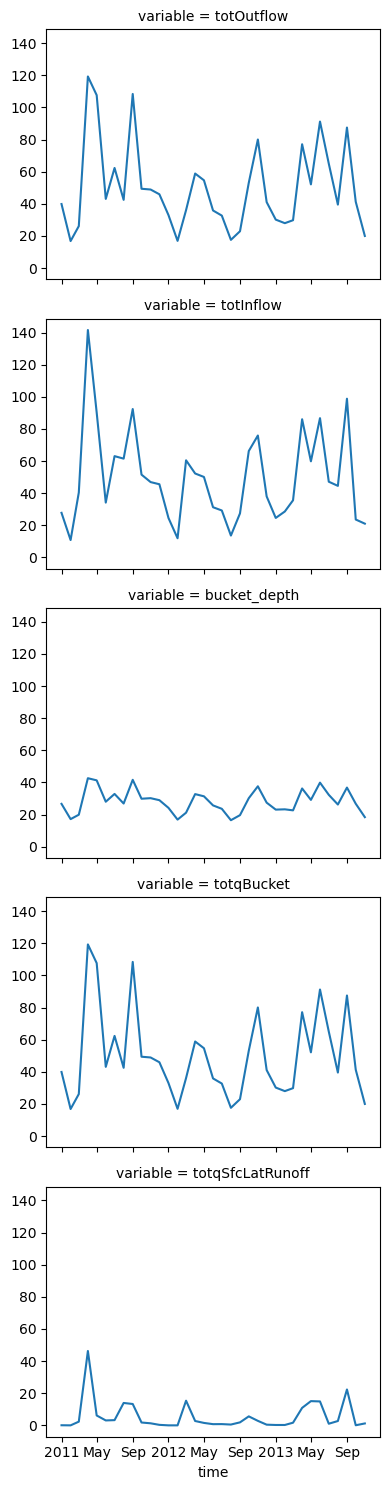

In [12]:
# Plot all variables to see ranges of values
vars_to_plot = [variable for variable in out_ds2.data_vars if variable not in ['totStreamflow', 'Area_sqkm']] 
out_ds2[vars_to_plot].isel({zone_name:2}).to_array().plot(row='variable')

In [12]:
out_ds2.close()

In [13]:
print('Process completed in {0: 3.2f} seconds.'.format(time.time()-tic))

Process completed in  8256.05 seconds.
